In [2]:
using JuMP, HiGHS
using Plots;
using VegaLite  # to make some nice plots
using DataFrames, CSV, PrettyTables
include("../src/utils.jl")
include("../src/unit_commitments.jl")
include("../src/network_analysis.jl")
include("../src/plots.jl")
ENV["COLUMNS"]=120;

gen_df, gen_var_long, loads_long, network = process_data("../WECC")

zone_dict = Dict(zip(gen_df.zone, gen_df.zone_name));
line_dict = Dict(zip(network.network_lines, network."transmission path name"));

In [3]:
# A spring day
n=100
initial_time = n*24+6
final_time = n*24+30
T_period = (initial_time):(final_time)

loads_multi = loads_long[in.(loads_long.hour,Ref(T_period)),:]
gen_var_multi = gen_var_long[in.(gen_var_long.hour, Ref(T_period)), :]

uc_solution = uc_with_transport(
    gen_df, loads_multi, gen_var_multi, network, 0.01); #1% MIP Gap

Running HiGHS 1.11.0 (git hash: 364c83a51e): Copyright (c) 2025 HiGHS under MIT licence terms
MIP  has 51324 rows; 27300 cols; 153375 nonzeros; 10425 integer variables (10425 binary)
Coefficient ranges:
  Matrix [3e-01, 8e+03]
  Cost   [4e+00, 1e+06]
  Bound  [1e+00, 2e+03]
  RHS    [1e+00, 3e+04]
Presolving model
36965 rows, 26870 cols, 132488 nonzeros  0s
28077 rows, 21432 cols, 114718 nonzeros  0s
20849 rows, 19722 cols, 104541 nonzeros  0s
17632 rows, 16812 cols, 99758 nonzeros  1s
16093 rows, 15376 cols, 95231 nonzeros  2s

Solving MIP model with:
   16093 rows
   15376 cols (8838 binary, 0 integer, 0 implied int., 6538 continuous, 0 domain fixed)
   95231 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; J => Feasibility jump;
     H => Heuristic; L => Sub-MIP; P => Empty MIP; R => Randomized rounding; Z => ZI Round;
     I => Shifting; S => Solve LP; T => Evaluate node; U => Unbounded; X => User solution;
     z => Trivial zero; l => Trivial lower; u =

In [4]:
# perturb data
gen_var_actuals = copy(gen_var_multi)
# gen_var_actuals.cf .= gen_var_actuals.cf .* (0.95 .+ 0.1 .* rand(nrow(gen_var_actuals)));

# Create actual loads (perturbed)
loads_actual = copy(loads_multi)
loads_actual.demand .= loads_actual.demand .* 1.1;

times = 6:18 # interior recommit times
ruc_solutions = Dict{Int, Any}()
for recommit_time in times
    recommit_hour = initial_time + recommit_time
    T_period_ruc = recommit_hour:final_time

    loads_multi_ruc = loads_multi[in.(loads_multi.hour, Ref(T_period_ruc)), :]
    gen_var_multi_ruc = gen_var_multi[in.(gen_var_multi.hour, Ref(T_period_ruc)), :]

    ruc_solution = reliability_uc(
        uc_solution.decision_vars, 
        recommit_hour,
        gen_df, 
        loads_multi_ruc, 
        gen_var_multi_ruc, 
        network, 0.01); #1% MIP Gap
    ruc_solutions[recommit_time] = ruc_solution
end

Running HiGHS 1.11.0 (git hash: 364c83a51e): Copyright (c) 2025 HiGHS under MIT licence terms
MIP  has 39185 rows; 20748 cols; 113144 nonzeros; 7923 integer variables (5592 binary)
Coefficient ranges:
  Matrix [3e-01, 8e+03]
  Cost   [4e+00, 1e+06]
  Bound  [1e+00, 2e+03]
  RHS    [3e-01, 3e+04]
Presolving model
22326 rows, 16830 cols, 70325 nonzeros  0s
15237 rows, 12309 cols, 55855 nonzeros  0s
10977 rows, 11294 cols, 49759 nonzeros  0s
9089 rows, 9817 cols, 45965 nonzeros  0s
7661 rows, 8389 cols, 43109 nonzeros  0s
7327 rows, 8257 cols, 41511 nonzeros  1s

Solving MIP model with:
   7327 rows
   8257 cols (4053 binary, 0 integer, 0 implied int., 4204 continuous, 0 domain fixed)
   41511 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; J => Feasibility jump;
     H => Heuristic; L => Sub-MIP; P => Empty MIP; R => Randomized rounding; Z => ZI Round;
     I => Shifting; S => Solve LP; T => Evaluate node; U => Unbounded; X => User solution;
     z => Trivial

In [5]:
actual_solutions = Dict{Int, Any}()
for recommit_time in times
    recommit_hour = initial_time + recommit_time
    ruc_actual_solution = evaluate_ruc_commitment_on_actuals(
        uc_solution,
        ruc_solutions[recommit_time],
        recommit_hour, 
        gen_df, 
        loads_actual,  # Use actual perturbed loads
        gen_var_actuals,  # Use actual perturbed renewables
        network,
        0.01
    )
    actual_solutions[recommit_time] = ruc_actual_solution
end

Running HiGHS 1.11.0 (git hash: 364c83a51e): Copyright (c) 2025 HiGHS under MIT licence terms
MIP  has 37852 rows; 20350 cols; 89267 nonzeros; 3475 integer variables (0 binary)
Coefficient ranges:
  Matrix [3e-01, 8e+03]
  Cost   [1e+00, 1e+04]
  Bound  [1e+00, 1e+00]
  RHS    [2e+00, 3e+05]
Presolving model
5089 rows, 4965 cols, 13170 nonzeros  0s
1771 rows, 3622 cols, 7308 nonzeros  0s
1771 rows, 3622 cols, 7308 nonzeros  0s

Solving MIP model with:
   1771 rows
   3622 cols (0 binary, 0 integer, 0 implied int., 3622 continuous, 0 domain fixed)
   7308 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; J => Feasibility jump;
     H => Heuristic; L => Sub-MIP; P => Empty MIP; R => Randomized rounding; Z => ZI Round;
     I => Shifting; S => Solve LP; T => Evaluate node; U => Unbounded; X => User solution;
     z => Trivial zero; l => Trivial lower; u => Trivial upper; p => Trivial point

        Nodes      |    B&B Tree     |            Objective Bounds      

In [6]:
# Collect performance metrics for each recommitment time
results_df = DataFrame(
    recommit_time = Int[],
    total_cost = Float64[],
    load_shed = Float64[],
    curtailment = Float64[],
    co2_emissions = Float64[]
)

for recommit_time in times
    sol = actual_solutions[recommit_time]
    push!(results_df, (
        recommit_time,
        sol.objective,
        sol.total_loadshed,
        sol.total_curtailment,
        sol.total_co2
    ))
end

println("Performance Metrics by Recommitment Time:")
pretty_table(results_df)

Performance Metrics by Recommitment Time:
┌───────────────┬────────────┬───────────┬─────────────┬───────────────┐
│ recommit_time │ total_cost │ load_shed │ curtailment │ co2_emissions │
│         Int64 │    Float64 │   Float64 │     Float64 │       Float64 │
├───────────────┼────────────┼───────────┼─────────────┼───────────────┤
│             6 │  4.87427e7 │   4704.69 │     10424.6 │     1.10843e6 │
│             7 │   4.7401e7 │   4570.59 │     16962.1 │     1.10853e6 │
│             8 │  4.74006e7 │   4570.59 │     20613.5 │     1.10859e6 │
│             9 │  2.79554e7 │   2625.55 │     13541.5 │     1.10971e6 │
│            10 │  2.90046e7 │   2730.46 │     20529.3 │     1.10969e6 │
│            11 │  3.91816e7 │   3748.46 │     15198.2 │     1.10952e6 │
│            12 │  2.90661e7 │   2736.48 │     15313.2 │     1.11015e6 │
│            13 │   3.0346e7 │   2864.46 │     19547.4 │     1.11022e6 │
│            14 │  4.05231e7 │   3882.46 │     15827.6 │     1.10996e6 │
│        

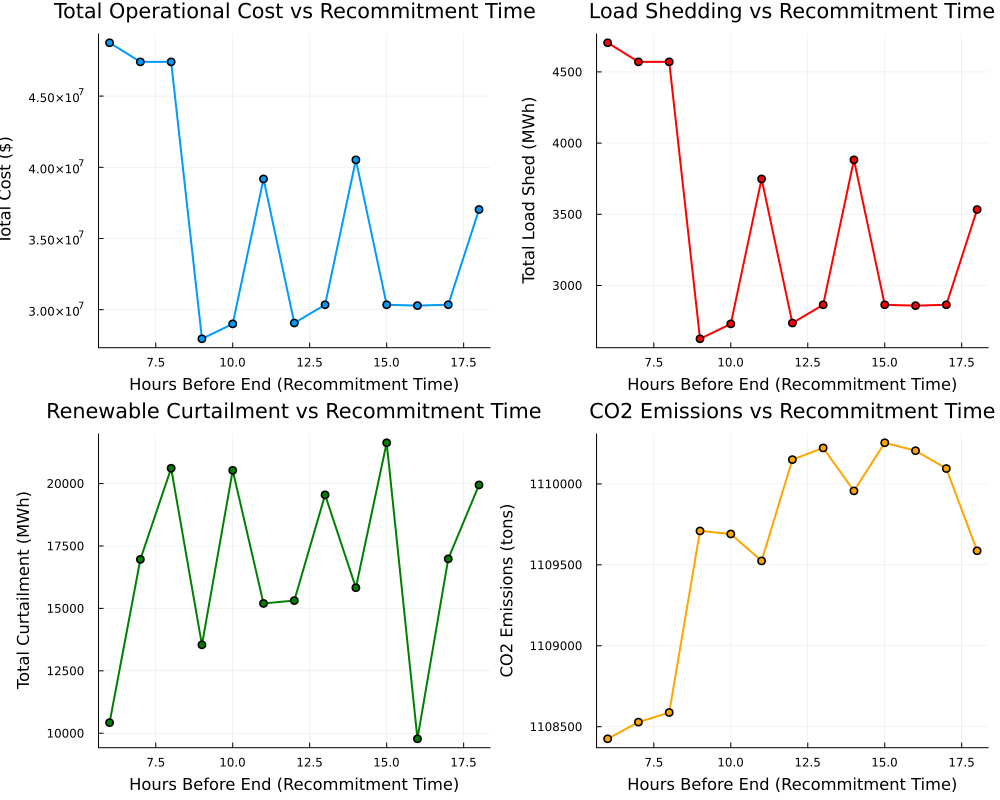

In [7]:
# Visualize the impact of recommitment timing
p1 = plot(results_df.recommit_time, results_df.total_cost,
    xlabel="Hours Before End (Recommitment Time)",
    ylabel="Total Cost (\$)",
    title="Total Operational Cost vs Recommitment Time",
    marker=:circle,
    linewidth=2,
    legend=false,
    grid=true
)

p2 = plot(results_df.recommit_time, results_df.load_shed,
    xlabel="Hours Before End (Recommitment Time)",
    ylabel="Total Load Shed (MWh)",
    title="Load Shedding vs Recommitment Time",
    marker=:circle,
    linewidth=2,
    legend=false,
    grid=true,
    color=:red
)

p3 = plot(results_df.recommit_time, results_df.curtailment,
    xlabel="Hours Before End (Recommitment Time)",
    ylabel="Total Curtailment (MWh)",
    title="Renewable Curtailment vs Recommitment Time",
    marker=:circle,
    linewidth=2,
    legend=false,
    grid=true,
    color=:green
)

p4 = plot(results_df.recommit_time, results_df.co2_emissions,
    xlabel="Hours Before End (Recommitment Time)",
    ylabel="CO2 Emissions (tons)",
    title="CO2 Emissions vs Recommitment Time",
    marker=:circle,
    linewidth=2,
    legend=false,
    grid=true,
    color=:orange
)

plot(p1, p2, p3, p4, layout=(2,2), size=(1000, 800))

Comparing Best (hour 9) vs Worst (hour 6) Recommitment Times


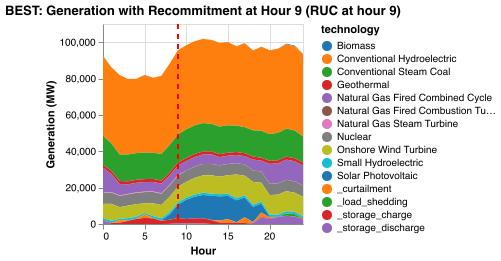

In [8]:
# Compare best vs worst recommitment time visually
best_loadshed_idx = argmin(results_df.load_shed)
best_time = results_df.recommit_time[best_loadshed_idx]
worst_time = results_df.recommit_time[argmax(results_df.load_shed)]

println("Comparing Best (hour $best_time) vs Worst (hour $worst_time) Recommitment Times")

# Plot generation comparison for best case
plot_actual_ruc_generation(
    actual_solutions[best_time],
    initial_time,
    best_time,
    gen_df,
    zone_dict,
    "BEST: Generation with Recommitment at Hour $best_time"
);

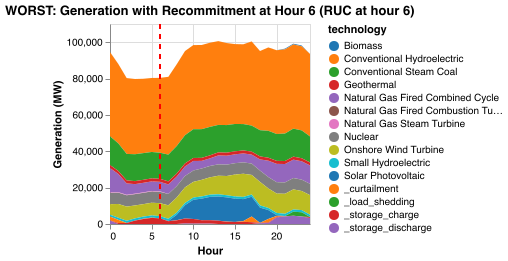

In [9]:
# Plot generation comparison for worst case
plot_actual_ruc_generation(
    actual_solutions[worst_time],
    initial_time,
    worst_time,
    gen_df,
    zone_dict,
    "WORST: Generation with Recommitment at Hour $worst_time"
);